In [0]:
import cvxpy as cp
import numpy as np
from scipy.special import ndtri
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [0]:
class simple_env(object):
  def __init__(self, sig=5, x_o_init=15):
    self.T = 0.1
    self.A = np.matrix([[0,1],[0,0]])
    self.B = np.matrix([[0],[1]])
    
    self.Bw = np.matrix([[0],[1]])
  
    self.Ad = np.identity(2) + self.T * self.A
    self.Bd = self.T * self.B
    self.Bwd = self.T * self.Bw
      
    self.x_o_init= x_o_init
      
    self.x=np.matrix([[0],[10]])
    self.x_obstacle=np.matrix([[self.x_o_init],[13]])
      
    self.sig = sig
  
  def reset(self):
    
    self.x=np.matrix([[0],[10]])
    self.x_obstacle=np.matrix([[self.x_o_init],[13]])
    
    x=np.array(self.x)
    x_obstacle=np.array(self.x_obstacle)
    
    return x_obstacle[0][0]-x[0][0], x[1][0], x_obstacle[1][0]
  
  def step(self, a):
    
    self.x=np.matmul(self.Ad, self.x) + self.Bd*a
    self.x_obstacle=np.matmul(self.Ad, self.x_obstacle) + self.Bwd*self.sig*np.random.randn(1)
    
    x=np.array(self.x)
    x_obstacle=np.array(self.x_obstacle)
    
    return x_obstacle[0][0]-x[0][0], x[1][0], x_obstacle[1][0]

In [0]:
env = simple_env(sig=0.2)

In [0]:
class simple_MPC(object):
  def __init__(self, A, B, N, T, sig,
               u_max = 2,
               u_min = -4,
               du_max = 0.5,
               du_min = -1,
               v_ref=15,
               eps=0.1
              ):
    
    self.T = T
    self.A = A
    self.B = B
    self.N = N
    self.v_ref = v_ref
    self.u_max = u_max
    self.u_min = u_min
    self.du_max = du_max
    self.du_min = du_min
    self.safety_dis = 5
    self.eps=eps
    
    self.Bw = B
  
    self.Ad = np.eye(2) + self.T * self.A
    self.Bd = self.T * self.B
    self.Bwd = self.T * self.B
    
    self.x = cp.Variable((2, N+1))
    self.u = cp.Variable((1, N))
    
    # the front obstacle position prediction
    self.x_o = cp.Parameter((1, N+1))
    
    # initial condition parameter
    self.x_int = cp.Parameter((2, ))
    self.u_int = cp.Parameter()
      
    self.sig = sig
    
    self.cost_base, self.constr_base = self._forward_extension(self.Ad, self.Bd, self.x, self.u, self.x_o, self.x_int, self.u_int)
    
  def _forward_extension(self, A, B, x, u, x_o, x_int, u_int):
    cost = 0
    constr = []
    
    for n in range(self.N):
      
      #transition
      constr += [x[:,n+1] == A*x[:,n] + B*u[:,n]]
      
      #input boundary
      constr += [u[:,n] >= self.u_min, u[:,n] <= self.u_max]
      if n+1 < self.N:
        constr += [u[:,n+1]-u[:,n] >= self.du_min, u[:,n+1]-u[:,n] <= self.du_max] 
      
      #safety distance constraint
      constr += [np.matrix([[1,0]])*x[:, n+1] + self.safety_dis - x_o[:, n+1] <= 0]
      
      cost += cp.sum_squares(x[1,n+1]-self.v_ref) + 0.1 * cp.sum_squares(u[:,n])
      
    #initial condition constraint
    constr += [x[:,0]==x_int]
    constr += [u[:,0]-u_int >= self.du_min, u[:,0]-u_int <= self.du_max]
    
    return cost, constr
    
  
  def plan_u(self, d_0, v_0, v_f, u_int):
    
    self.x_o.value = self.disturbance_sampling(np.matrix([[d_0],[v_f]]))
    
    self.x_int.value = np.array([0, v_0])
    self.u_int.value = u_int
    
    problem = cp.Problem(cp.Minimize(self.cost_base), self.constr_base)
    problem.solve()
    
    return self.x.value, self.u.value, problem.status, self.x_o.value
  
  def disturbance_sampling(self, s_o):
    
    x_o=[]
    P_o=np.zeros([2,2])
    
    x_o.append(s_o[0,:])
    
    for _ in range(self.N):
      
      s_o=np.matmul(self.Ad, s_o)
      P_o=self.Ad*P_o*self.Ad.T + self.Bd*(self.sig**2)*self.Bd.T
      
      x_o.append(s_o[0,:] + ndtri(self.eps)*P_o[1, 1])
      
    x_o = np.vstack(x_o)
      
    return x_o.T
    

In [0]:
def plot():
    clear_output(True)
    plt.figure(figsize=(8, 16))
    plt.subplot(211)
    plt.plot(np.vstack(step_list), np.vstack(d_list))
    plt.ylabel('distance')
    plt.subplot(212)
    plt.plot(np.vstack(step_list), np.vstack(v_list))
    plt.ylabel('velocity')
    plt.xlabel('time')
    plt.show()

In [0]:
np.random.seed(1234)
N_step = 10
dT = 0.4
controller = simple_MPC(env.A, env.B, N_step, dT, env.sig)

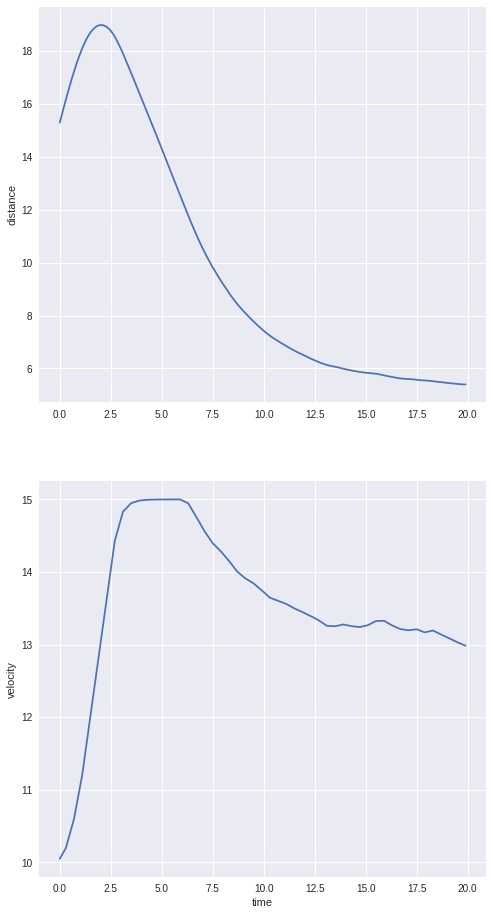

In [0]:
d, v_s, v_f = env.reset()

print(d)
print(v_s)
print(v_f)

step_list=[]
d_list=[]
v_list=[]
u_last=0

for step in range(0, 200):
  
  if step % 4 ==0:
    # every 4s, controller plans u
    x_pre, u_pre, status, x_o_pre = controller.plan_u(d, v_s, v_f, u_last)
    print('status : ', status)
    u_last = u_pre[0,0]
  
  d, v_s, v_f = env.step(u_last)
  print('Distance : {:.4}'.format(d))
  print('velocity : {:.4}'.format(v_s))
  print('obstacle velocity : {:.4}'.format(v_f))
  #print('obstacle collision prediction: ', x_pre[0] + controller.safety_dis > x_o_pre)
  np.set_printoptions(precision=3, suppress=True)
  
  
  step_list.append(np.array(env.T*step))
  d_list.append(np.array(d))
  v_list.append(np.array(v_s))
  
  plot()
  
